In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [272]:
import pandas as pd
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
# tiff access
from PIL import Image
from PIL.TiffTags import TAGS

# Dataset metadata file

It is a good idea to create a csv with the relevant information of the dataset:
- pat_id, image and lesion paths, endpoint labels, etc.
This later can be used to create the dataset object.

In [116]:
# read valid patients num
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_reldir = Path('data/images/SET')
# make index a string
labels_csv  = pd.read_csv(repo_path / 'data/images/labels/raw_labels.csv', index_col=0, dtype=str)
labels_csv.index = labels_csv.index.astype(str)

In [357]:
# use pat num as index
df = pd.DataFrame(index=valid_patients['pat_num'])
for pat_num in df.index:
    # images
    im_path = image_reldir / f'Pat_{pat_num}_SET_SMC_to_CMC_1min.tif'
    df.loc[pat_num, 'SET_path'] = str(im_path)
    df.loc[pat_num, 'SMC_path'] = f'data/images/pre-SET/Pat_{pat_num.zfill(2)}_RCC_SMC.tif'
    for i in range(1, 5):
        df.loc[pat_num, f'CMC-t{i}_path'] = f'data/images/pre-SET/Pat_{pat_num.zfill(2)}_RCC_CMC_t{i}.tif'
    # binary masks
    for rad in ['L', 'M', 'V']:
        for time in ['1', '2']:
            df.loc[pat_num, f'{rad}_{time}_G'] = f'data/fixed_binary_masks/{rad}_{time}_seg/{pat_num}_G_{rad}.seg.nrrd'
    # RE label 1 if POSITIVO, 0 if NEGATIVO, -1 if INDETERMINADO
    df.loc[pat_num, 'RE'] = 1 if labels_csv.loc[pat_num, 'RE'] == 'POSITIVO' else 0 if labels_csv.loc[pat_num, 'RE'] == 'NEGATIVO' else -1
    # same for RP
    df.loc[pat_num, 'RP'] = 1 if labels_csv.loc[pat_num, 'RP'] == 'POSITIVO' else 0 if labels_csv.loc[pat_num, 'RP'] == 'NEGATIVO' else -1
    # same for HER2
    df.loc[pat_num, 'HER2'] = 1 if labels_csv.loc[pat_num, 'HER 2'] == 'POSITIVO' else 0 if labels_csv.loc[pat_num, 'HER 2'] == 'NEGATIVO' else -1
    # For KI67 1 if > 0.2, 0 if <= 0.2, -1 if INDETERMINADO
    df.loc[pat_num, 'KI67'] = 1 if float(labels_csv.loc[pat_num, 'KI67']) > 0.2 else 0 if float(labels_csv.loc[pat_num, 'KI67']) <= 0.2 else -1
    
    # visualization window
    im = Image.open(repo_path / im_path)
    im_descrip = im.tag_v2[270]
    im_descrip = im_descrip.split('\n')
    min_visual = int(float(im_descrip[5].split('=')[1]))
    max_visual = int(float(im_descrip[6].split('=')[1]))
    df.loc[pat_num, 'min_visual'] = min_visual
    df.loc[pat_num, 'max_visual'] = max_visual
# turn all labels to int
df[['RE', 'RP', 'HER2', 'KI67']] = df[['RE', 'RP', 'HER2', 'KI67']].astype(int)

# save to csv in data
df.to_csv(repo_path / 'data/dataset_info.csv')

Now we add the min-max visualization information included in the tiff header.

## 1.2. Dataset object:

In [358]:
class dataset_INCan():
    """Class to access general info (paths and labels) from csv of ALL PATIENTS
    """
    def __init__(self, meta_path:Path = repo_path / 'data/dataset_info.csv') -> None:
        """dataset object for INCan dataset

        Args:
            meta_path (Path, optional): csv file path to create the object. Defaults to repo_path/'data/dataset_info.csv'.
        """
        self.meta = pd.read_csv(str(meta_path), index_col='pat_num', dtype={'pat_num':str})
        self.pat_num = list(self.meta.index)
        self.len = len(self.pat_num)

    def __repr__(self) -> str:
        return f'dataset object with {self.len} patients'
    
    def im_path(self, sequence: str, t = 't1'):
        """gets the image paths of the current meta dataframe

        Args:
            sequence (str): SMC, CMC or SET
            t (str, optional): Only for CMC (and SET). Defaults to 't1'.

        Returns:
            list: list with the paths of the images
        """
        # sequence definition
        im_seq = f'{sequence}-{t}_path' if sequence=='CMC' else f'{sequence}_path' if sequence=='SET' or sequence=='SMC' else None
        if im_seq is None:
            raise ValueError(f'not a correct sequence. Choose between SMC, CMC or SET. You chose {sequence}')
        paths = getattr(self.meta, im_seq)
        
        return list(paths)

    def seg_path(self, rad: str, time: int, stype: str='G'):
        """get paths list of segmentation given the radiologist, the time and the segmentation type

        Args:
            rad (str): Lily, Vyanka or Martha
            time (str): 1 or 2
            stype (str): global or focal

        Returns:
            list: paths of segmentation
        """
        seg_name = f'{rad}_{time}_{stype}'
        paths = getattr(self.meta, seg_name)
        return list(paths)
    

    def labels_list(self, receptor: str):
        """get labels of the patients
_description_
        Args:
            receptor (str): 'ER', 'PR' or 'HER2'

        Returns:
            list: list with labels of the patients
        """
        labels = getattr(self.meta, receptor)
        return list(labels)
    
class patient(dataset_INCan): #inherit from path_label path and seg functions
    """Class to access patient information
    """
    def __init__(self, pat_num:str, dataset = dataset_INCan()) -> None:
        """use metadata from info for each patient

        Args:
            info (obj, optional): info object. Defaults to path_label().
            num (int, optional): index of the patient (not patient number) Starts from 0. Defaults to 0.
        """
        self.meta = dataset.meta.loc[[pat_num]]
        self.pat_num = pat_num
    
    def __repr__(self) -> str:
        return f'patient object of number {self.pat_num}'
    
    def get_im(self, sequence: str, t = 't1', format:str = 'np', SET_corrected: bool = True):
        """get the image array of the patient

        Args:
            sequence (str): SMC, CMC or SET
            t (str, optional): Only for CMC (and SET). Defaults to 't1'.

        Returns:
            numpy array: image array
        """
        im_path = repo_path / self.im_path(sequence, t)[0]
        im_sitk = sitk.ReadImage(str(im_path))
        if format =='sitk':
            return im_sitk
        im_array = sitk.GetArrayFromImage(im_sitk)
        if sequence == 'SET' and SET_corrected:
            im_array = im_array.astype(np.int32)
            im_array = (im_array - np.power(2,15)).astype(np.int16)
        
        return im_array
    
    def get_seg(self, rad: str, time: int, stype: str='G', format:str = 'np'):
        """get the segmentation array of the patient

        Args:
            rad (str): Lily, Vyanka or Martha
            time (str): 1 or 2
            stype (str): global or focal

        Returns:
            numpy array: segmentation array
        """
        seg_path = repo_path / self.seg_path(rad, time, stype)[0]
        seg_sitk = sitk.ReadImage(str(seg_path))
        if format =='sitk':
            return seg_sitk
        seg_array = sitk.GetArrayFromImage(seg_sitk)
        return seg_array


/tmp/ipykernel_12090/3833645866.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.imshow(pat.get_im('SET', SET_corrected=True), cmap='gray', vmax=pat.meta['max_visual'][0]-np.power(2,15), vmin=pat.meta['min_visual'][0]-np.power(2,15))


(-0.5, 2363.5, 2963.5, -0.5)

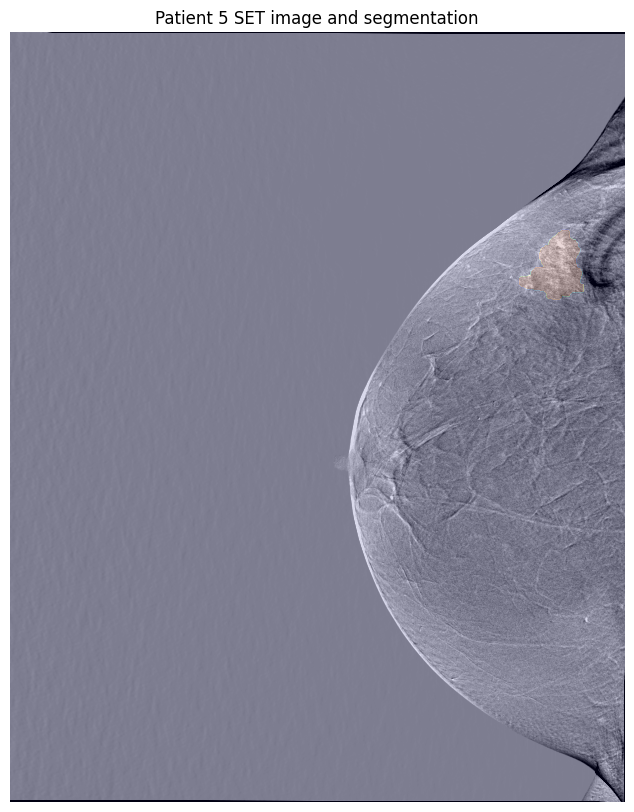

In [380]:
dataset = dataset_INCan()
id_num = dataset.pat_num[3]
pat = patient(id_num, dataset)

# plot image and segmentation superimposed
plt.figure(figsize=(10,10))
plt.imshow(pat.get_im('SET', SET_corrected=True), cmap='gray', vmax=pat.meta['max_visual'][0]-np.power(2,15), vmin=pat.meta['min_visual'][0]-np.power(2,15))
plt.imshow(pat.get_seg('V', 1), cmap='jet', alpha=0.15)
plt.title(f'Patient {id_num} SET image and segmentation')
plt.axis('off')